# Multi-dimensional deconvolution with stochastic gradient algorithms

In this notebook, we revisit the MDD problem and solve it by means of stochastic gradient algorithms implemented in Pytorch. Whilst this is not really beneficial, this represent a first step towards our minibatch implementation in the following notebook.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import cProfile
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import torch
import torchvision
import torch.nn as nn
import pylops_gpu


from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from tqdm.notebook import tqdm_notebook, tnrange
from torch.autograd import gradcheck
from pylops_gpu.utils.backend import device
from torch.nn import MSELoss
from torch.utils.data import Dataset, DataLoader

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *

from stochmdd import MDDbatch

## Data creation

In [2]:
###### Input parameters
par = {'ox':-300,  'dx':10,    'nx':61,
       'oy':-500,  'dy':10,    'ny':101,
       'ot':0,     'dt':0.004, 'nt':400,
       'f0': 20,   'nfmax': 200}

t0_m    = [0.2]
vrms_m  = [1100.]
amp_m   = [1.]

t0_G    = [0.2,0.5,0.7]
vrms_G  = [1200.,1500., 2000.]
amp_G   = [1.,0.6,0.5]

ns = par['ny']
nr = par['nx']
nt = par['nt']
nfmax = par['nfmax']
dr = par['dx']
ds = par['dy']
dt = par['dt']
f0 = par['f0']

# Create taper for operator
tap = taper3d(nt, (ns,nr), [5,5], tapertype='hanning')

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0)[0]

# Generate model
m, mwav = hyperbolic2d(x,t,t0_m,vrms_m,amp_m,wav)

# Generate operator
G, Gwav = np.zeros((ns,nr,nt)), np.zeros((ns,nr,nt))
for iy, y0 in enumerate(y):
    G[iy],Gwav[iy] = hyperbolic2d(x-y0,t,t0_G,vrms_G,amp_G,wav)
G, Gwav = G*tap, Gwav*tap

In [3]:
# Add negative part to operator and model
m = np.concatenate((np.zeros((nr, nt-1)), m), axis=-1).T
mwav = np.concatenate((np.zeros((nr, nt-1)), mwav), axis=-1).T
Gwav2 = np.concatenate((np.zeros((ns, nr, nt-1)), Gwav), axis=-1)

In [4]:
# Create frequency domain operator
Gwav_fft = np.fft.rfft(Gwav2, 2*nt-1, axis=-1)
Gwav_fft = Gwav_fft[...,:nfmax]
Gwav_fft = Gwav_fft.transpose(2,0,1)

# Create operator
MDCop=MDC(Gwav_fft, nt=2*nt-1, nv=1, dt=dt, dr=dr, 
          twosided=True, transpose=False)
dottest(MDCop, MDCop.shape[0], MDCop.shape[1], complexflag=0, verb=True)

# Create data
d = MDCop * m.ravel()
d = d.reshape(2*nt-1, ns)

# Convert to torch tensors
d = torch.from_numpy(d)
m = torch.from_numpy(m)

Dot test passed, v^T(Opu)=165.078784 - u^T(Op^Tv)=165.078784


In [5]:
niter = 50

lossdict = {}
avgdict = {}
enormdict = {}
mdict = {}

# SGD optimization

In [6]:
model, dmod, lossdict['SGD'], avgdict['SGD'], enormdict['SGD'] = \
                 MDDbatch(nt, nr, dt, dr, Gwav_fft, d, torch.optim.SGD, niter,
                          mtrue=m, **dict(lr=1., weight_decay=0))
                 
mdict["SGD"] = model.detach().numpy()

Epoch:  10, loss : 7.2444e-02, loss avg : 2.6444e-01
Epoch:  20, loss : 3.1357e-02, loss avg : 1.5460e-01
Epoch:  30, loss : 1.9138e-02, loss avg : 1.1098e-01
Epoch:  40, loss : 1.3437e-02, loss avg : 8.7163e-02
Epoch:  50, loss : 1.0213e-02, loss avg : 7.2036e-02


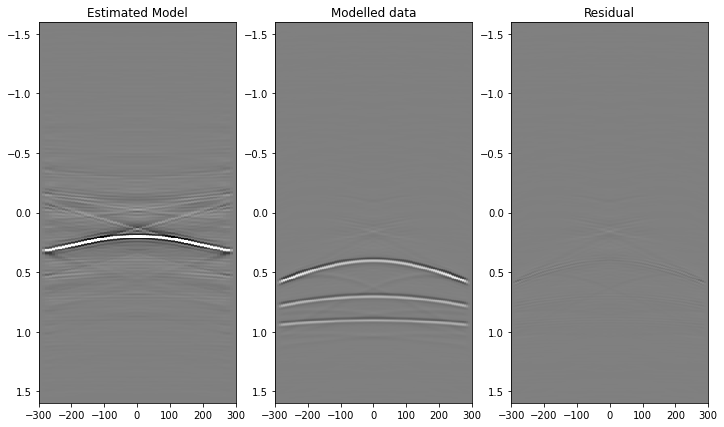

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize= (12,7))
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.1, vmax=0.1,
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('Estimated Model')
ax2.imshow(dmod.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('Modelled data')
ax3.imshow((dmod-d).detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax3.set_title('Residual');

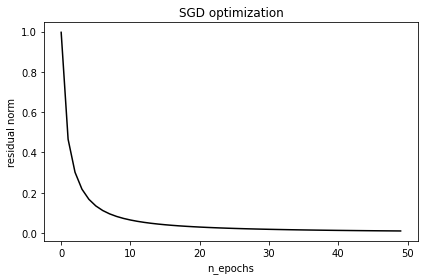

In [8]:
plt.plot(lossdict['SGD'], 'k')
plt.title('SGD optimization', fontsize=12)
plt.xlabel('n_epochs')
plt.ylabel('residual norm')
plt.tight_layout()

# SGD with momentum optimization

In [9]:
model, dmod, lossdict['SGDMom'], avgdict['SGDMom'], enormdict['SGDMom'] = \
                 MDDbatch(nt, nr, dt, dr, Gwav_fft, d, torch.optim.SGD, niter,
                          mtrue=m, **dict(lr=.5, weight_decay=0, momentum=0.9, dampening=0, nesterov=True))
                 
mdict["SGDMom"] = model.detach().numpy()

Epoch:  10, loss : 6.8460e-02, loss avg : 2.5418e-01
Epoch:  20, loss : 1.4784e-02, loss avg : 1.4215e-01
Epoch:  30, loss : 5.3611e-03, loss avg : 9.7588e-02
Epoch:  40, loss : 2.7261e-03, loss avg : 7.4103e-02
Epoch:  50, loss : 1.7959e-03, loss avg : 5.9711e-02


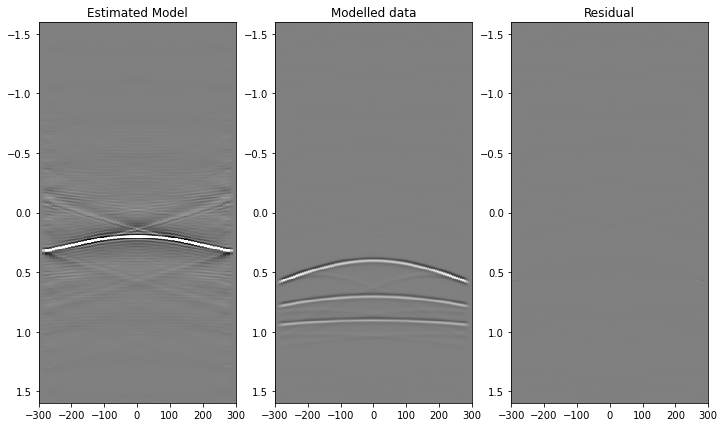

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize= (12,7))
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.1, vmax=0.1,
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('Estimated Model')
ax2.imshow(dmod.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('Modelled data')
ax3.imshow((dmod-d).detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax3.set_title('Residual');

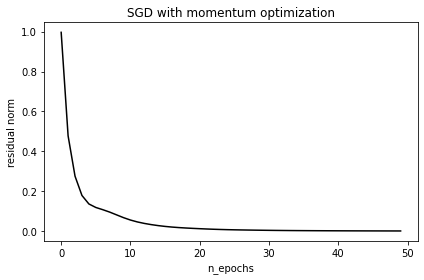

In [11]:
plt.plot(lossdict['SGDMom'], 'k')
plt.title('SGD with momentum optimization', fontsize=12)
plt.xlabel('n_epochs')
plt.ylabel('residual norm')
plt.tight_layout()

# Adagrad optimization

In [12]:
model, dmod, lossdict['Adagrad'], avgdict['Adagrad'], enormdict['Adagrad'] = \
                 MDDbatch(nt, nr, dt, dr, Gwav_fft, d, torch.optim.Adagrad, niter,
                          mtrue=m, **dict(lr=.01, eps=1e-6, weight_decay=1e-2))
                 
mdict["Adagrad"] = model.detach().numpy()

Epoch:  10, loss : 2.8931e-01, loss avg : 6.2757e-01
Epoch:  20, loss : 1.9626e-01, loss avg : 4.3400e-01
Epoch:  30, loss : 1.3382e-01, loss avg : 3.4098e-01
Epoch:  40, loss : 1.0558e-01, loss avg : 2.8504e-01
Epoch:  50, loss : 8.6899e-02, loss avg : 2.4698e-01


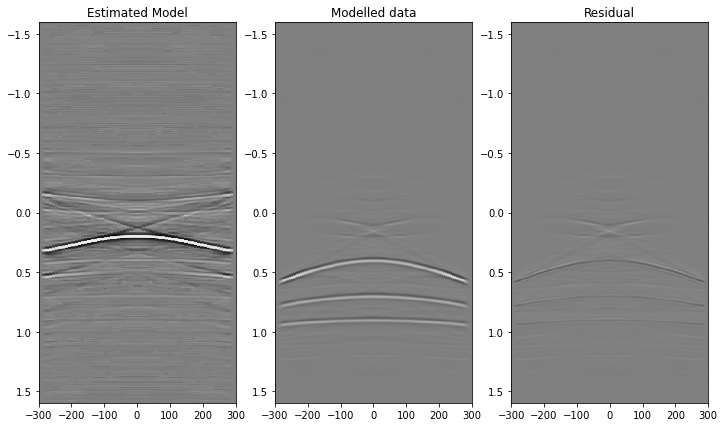

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize= (12,7))
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.1, vmax=0.1,
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('Estimated Model')
ax2.imshow(dmod.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('Modelled data')
ax3.imshow((dmod-d).detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax3.set_title('Residual');

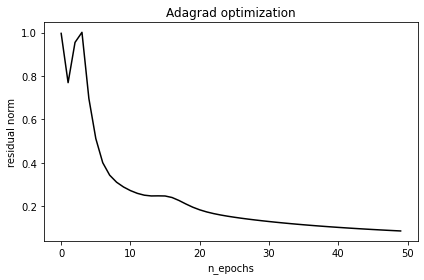

In [14]:
plt.plot(lossdict['Adagrad'], 'k')
plt.title('Adagrad optimization', fontsize=12)
plt.xlabel('n_epochs')
plt.ylabel('residual norm')
plt.tight_layout()

# Adadelta optimization

In [15]:
model, dmod, lossdict['Adadelta'], avgdict['Adadelta'], enormdict['Adadelta'] = \
                 MDDbatch(nt, nr, dt, dr, Gwav_fft, d, torch.optim.Adadelta, niter,
                          mtrue=m, **dict(lr=1., rho=0.6, weight_decay=1e-2))
                 
mdict["Adadelta"] = model.detach().numpy()

Epoch:  10, loss : 4.9581e-01, loss avg : 7.0689e-01
Epoch:  20, loss : 2.7239e-01, loss avg : 5.3301e-01
Epoch:  30, loss : 1.5667e-01, loss avg : 4.2307e-01
Epoch:  40, loss : 9.2696e-02, loss avg : 3.4687e-01
Epoch:  50, loss : 5.8302e-02, loss avg : 2.9190e-01


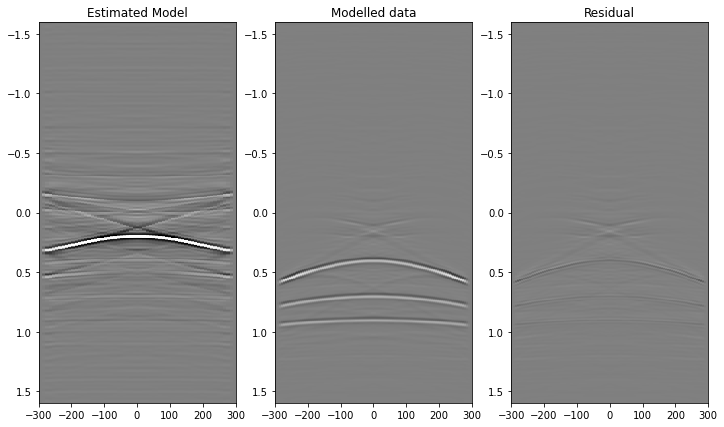

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize= (12,7))
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.1, vmax=0.1,
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('Estimated Model')
ax2.imshow(dmod.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('Modelled data')
ax3.imshow((dmod-d).detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax3.set_title('Residual');

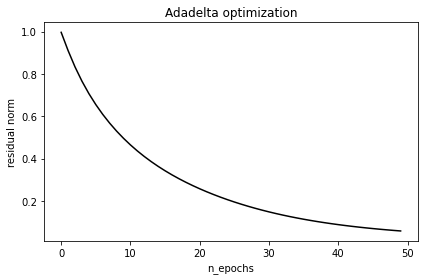

In [17]:
plt.plot(lossdict['Adadelta'], 'k')
plt.title('Adadelta optimization', fontsize=12)
plt.xlabel('n_epochs')
plt.ylabel('residual norm')
plt.tight_layout()

# Adam optimization

In [18]:
model, dmod, lossdict['Adam'], avgdict['Adam'], enormdict['Adam'] = \
                 MDDbatch(nt, nr, dt, dr, Gwav_fft, d, torch.optim.Adam, niter,
                          mtrue=m, **dict(lr=.01, eps=1e-5, weight_decay=1e-2))
                 
mdict["Adam"] = model.detach().numpy()

Epoch:  10, loss : 2.1590e-01, loss avg : 4.8748e-01
Epoch:  20, loss : 6.4346e-02, loss avg : 3.0226e-01
Epoch:  30, loss : 2.9904e-02, loss avg : 2.1577e-01
Epoch:  40, loss : 1.9658e-02, loss avg : 1.6756e-01
Epoch:  50, loss : 1.7201e-02, loss avg : 1.3768e-01


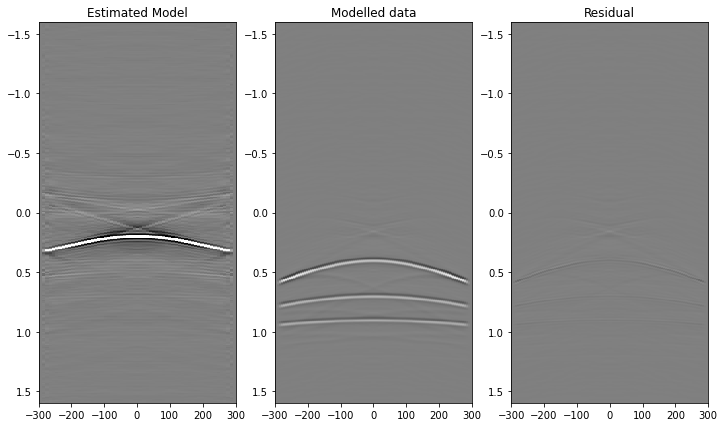

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize= (12,7))
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.1, vmax=0.1,
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('Estimated Model')
ax2.imshow(dmod.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('Modelled data')
ax3.imshow((dmod-d).detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax3.set_title('Residual');

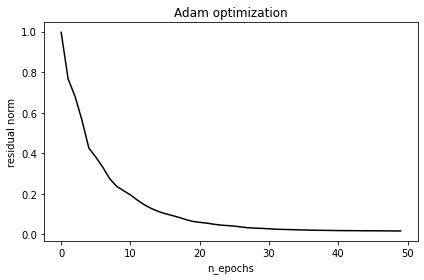

In [20]:
plt.plot(lossdict['Adam'], 'k')
plt.title('Adam optimization', fontsize=12)
plt.xlabel('n_epochs')
plt.ylabel('residual norm')
plt.tight_layout()

# RMSprop optimization

In [21]:
model, dmod, lossdict['RMSprop'], avgdict['RMSprop'], enormdict['RMSprop'] = \
                 MDDbatch(nt, nr, dt, dr, Gwav_fft, d, torch.optim.RMSprop, niter,
                          mtrue=m, **dict(lr=.001, alpha=0.8, centered=False, eps=1e-6, weight_decay=1e-2))
                 
mdict["RMSprop"] = model.detach().numpy()

Epoch:  10, loss : 5.7387e-01, loss avg : 7.3124e-01
Epoch:  20, loss : 4.1895e-01, loss avg : 6.0683e-01
Epoch:  30, loss : 3.2010e-01, loss avg : 5.2491e-01
Epoch:  40, loss : 2.5099e-01, loss avg : 4.6376e-01
Epoch:  50, loss : 1.9843e-01, loss avg : 4.1521e-01


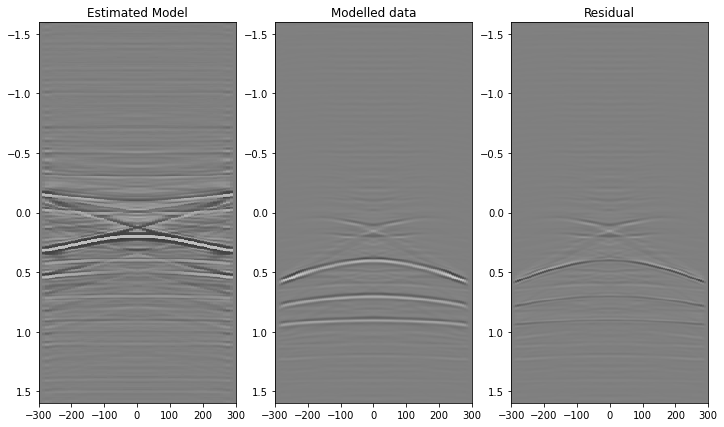

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize= (12,7))
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.1, vmax=0.1,
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('Estimated Model')
ax2.imshow(dmod.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('Modelled data')
ax3.imshow((dmod-d).detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.detach().numpy().max(), vmax=d.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax3.set_title('Residual');

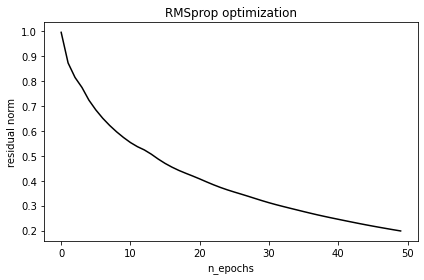

In [23]:
plt.plot(lossdict['RMSprop'], 'k')
plt.title('RMSprop optimization', fontsize=12)
plt.xlabel('n_epochs')
plt.ylabel('residual norm')
plt.tight_layout()

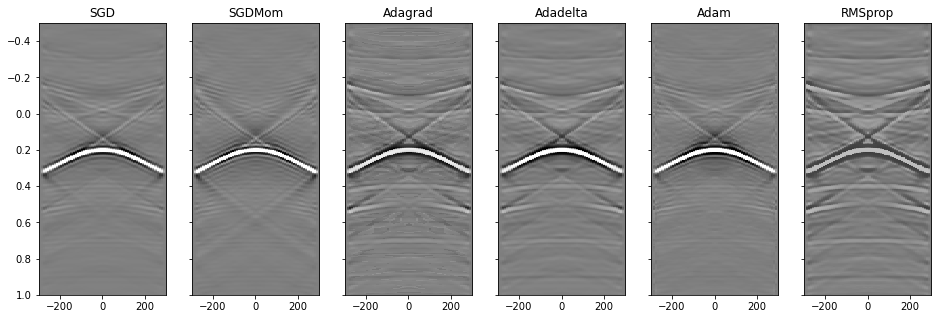

In [24]:
fig, axs = plt.subplots(1, len(mdict), sharey=True, figsize=(16, 5))
for iloss, loss in enumerate(mdict.keys()):
    axs[iloss].imshow(mdict[loss], aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.1, vmax=0.1,
           extent=(x.min(),x.max(),t2.max(),t2.min()))
    axs[iloss].axis('tight')
    axs[iloss].set_title(loss)
axs[-1].set_ylim(1., -0.5);

# Comparision

In [25]:
# Load standard time-domain MDD results
f = np.load('../MDD_basic_norms.npz') 

lsqr_cost = f['cost'] * Gwav2.shape[0]
lsqr_enorm = f['enorm']

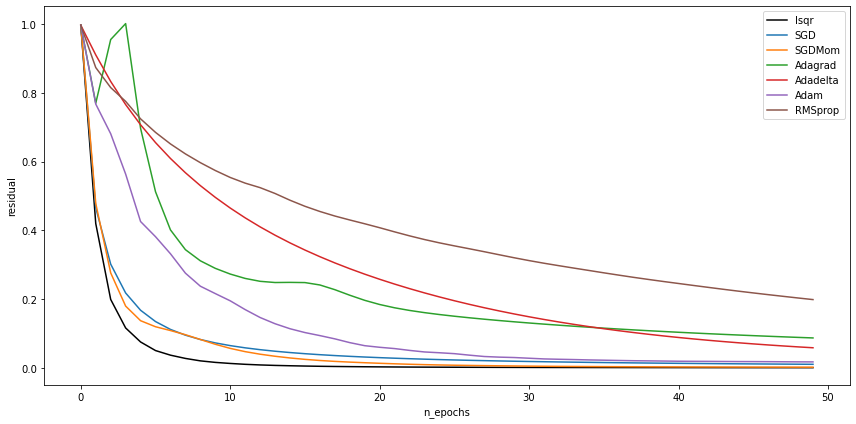

In [26]:
fig = plt.figure(figsize= (12,6))
plt.plot(lsqr_cost, 'k', label='lsqr')
for loss in lossdict.keys():
    plt.plot(lossdict[loss], label = loss)
plt.xlabel('n_epochs')
plt.ylabel('residual')
plt.legend()
plt.tight_layout()

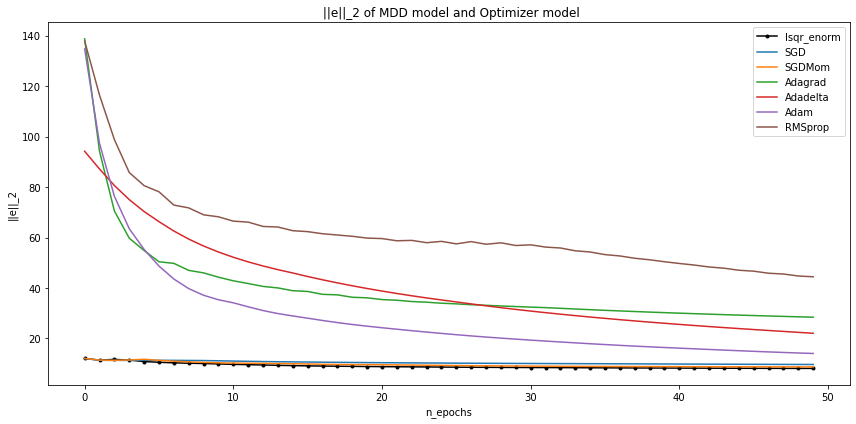

In [27]:
fig = plt.figure(figsize= (12,6))
plt.plot(lsqr_enorm, '.-k', label = "lsqr_enorm")
for enorm in enormdict.keys():
    plt.plot(enormdict[enorm], label=enorm)
    plt.ylabel('||e||_2')
    plt.xlabel('n_epochs')
    plt.title(" ||e||_2 of MDD model and Optimizer model")
    plt.legend()
    plt.tight_layout()

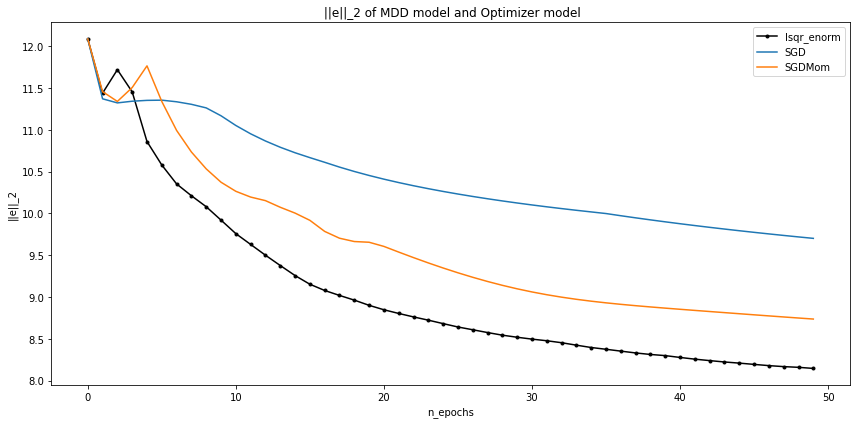

In [28]:
fig = plt.figure(figsize= (12,6))
plt.plot(lsqr_enorm, '.-k', label = "lsqr_enorm")
for enorm in ['SGD', 'SGDMom']:
    plt.plot(enormdict[enorm], label=enorm)
    plt.ylabel('||e||_2')
    plt.xlabel('n_epochs')
    plt.title(" ||e||_2 of MDD model and Optimizer model")
    plt.legend()
    plt.tight_layout()